In [1]:
runs = 6
train_accs = []
test_accs = []
dev_accs = []

In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
for run in range(runs):
        res_file = f'results/language_parser/train_defaults_jump{run}.json'

        # with open(attn_file, 'rb') as f:
        #     attn_maps = pickle.load(f)

        with open(res_file, 'r') as f:
            stats = json.load(f)

        dev_accs.append(stats.get('dev_accs'))
        train_accs.append(stats.get('train_accs'))
        test_accs.append(stats.get('test_accs'))

In [3]:
train_accs = np.array(train_accs).T
test_accs = np.array(test_accs).T
dev_accs = np.array(dev_accs).T

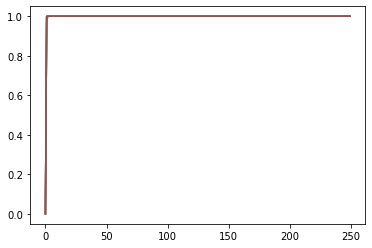

In [4]:
plt.plot(train_accs)

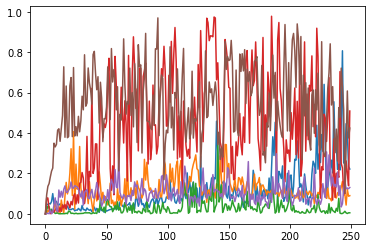

In [6]:
plt.plot(test_accs)

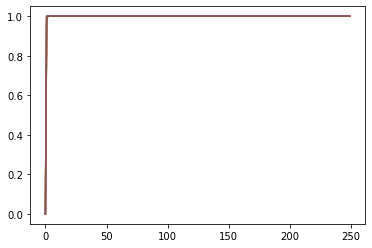

In [7]:
plt.plot(dev_accs)

Transformer Results

In [8]:
runs = 8
train_accs = []
test_accs = []
dev_accs = []

In [9]:
import numpy as np
import json
import matplotlib.pyplot as plt
for run in range(runs):
        res_file = f'results/transformer/train_defaults_jump{run}.json'

        # with open(attn_file, 'rb') as f:
        #     attn_maps = pickle.load(f)

        with open(res_file, 'r') as f:
            stats = json.load(f)

        dev_accs.append(stats.get('dev_accs'))
        train_accs.append(stats.get('train_accs'))
        test_accs.append(stats.get('test_accs'))

In [10]:
train_accs = np.array(train_accs).T
test_accs = np.array(test_accs).T
dev_accs = np.array(dev_accs).T

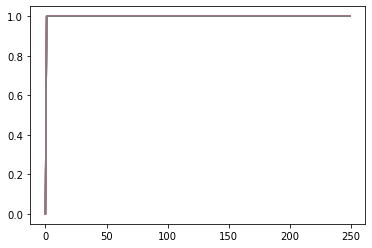

In [11]:
plt.plot(train_accs)

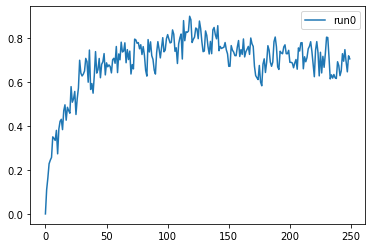

In [16]:
plt.plot(np.mean(test_accs, axis=1))
plt.legend(["run%d"%i for i in range(runs)])

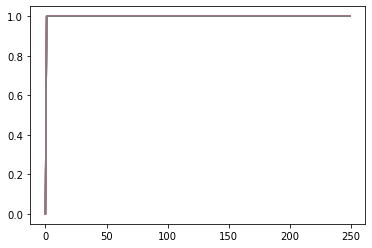

In [13]:
plt.plot(dev_accs)

In [18]:
runs = 1
train_accs = []
test_accs = []
dev_accs = []

In [19]:
import numpy as np
import json
import matplotlib.pyplot as plt
for run in range(runs):
        res_file = f'results/transformer/train_defaults_mcd1{run}.json'

        # with open(attn_file, 'rb') as f:
        #     attn_maps = pickle.load(f)

        with open(res_file, 'r') as f:
            stats = json.load(f)

        dev_accs.append(stats.get('dev_accs'))
        train_accs.append(stats.get('train_accs'))
        test_accs.append(stats.get('test_accs'))

In [20]:
train_accs = np.array(train_accs).T
test_accs = np.array(test_accs).T
dev_accs = np.array(dev_accs).T

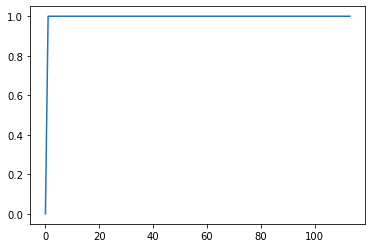

In [21]:
plt.plot(train_accs)

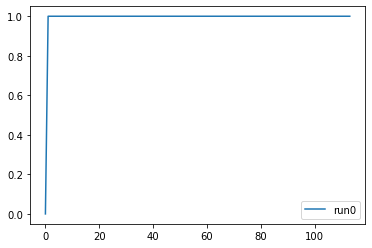

In [22]:
plt.plot(np.mean(test_accs, axis=1))
plt.legend(["run%d"%i for i in range(runs)])

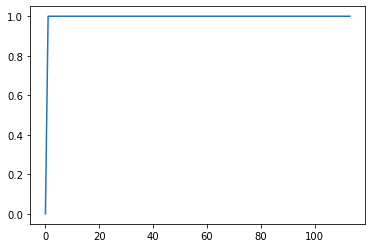

In [23]:
plt.plot(dev_accs)

In [ ]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()